In [140]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier  # or GradientBoostingClassifier if you prefer sklearn-only
import shap, seaborn as sns, matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer

df = pd.read_csv("../data/youtube_shorts_tiktok_trends_2025.csv_ML.csv")


In [141]:
# Sentiment from raw titles (aligns row-for-row with the _ML file)
sia = SentimentIntensityAnalyzer()
df_raw = pd.read_csv("../data/youtube_shorts_tiktok_trends_2025.csv", usecols=["title"])
df["title_sentiment"] = df_raw["title"].fillna("").apply(lambda t: sia.polarity_scores(t)["compound"])


In [142]:
import sys
sys.path.append("../src")

from preprocess import map_labels, clean_features, get_feature_matrix
from model_utils import rate_video


In [143]:
df_country = pd.read_csv("../data/country_platform_summary_2025.csv")
df_country.head()

df_country.rename(columns={'country': 'region'}, inplace=True)

df_enriched = df.merge(
    df_country[['region', 'platform', 'median_er', 'avg_velocity', 'avg_engagement_per_1k']],
    on=['region', 'platform'],
    how='left'
)
# Compute region+platform "strength" from your own ML data
region_platform_strength = (
    df.groupby(['region', 'platform'])
      .agg({
          'views_per_day': 'mean',
          'like_rate': 'mean',
          'share_rate': 'mean',
          'rel_like': 'mean',
          'rel_share': 'mean'
      })
      .reset_index()
      .rename(columns={
          'views_per_day': 'region_platform_avg_views_per_day',
          'like_rate': 'region_platform_avg_like_rate',
          'share_rate': 'region_platform_avg_share_rate',
          'rel_like': 'region_platform_avg_rel_like',
          'rel_share': 'region_platform_avg_rel_share'
      })
)

region_platform_strength.head()




,region,platform,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share
0,Africa,tiktok,0.125424,0.237473,0.070539,0.172764,0.334977
1,Africa,youtube,0.103872,0.205414,0.059469,0.014196,0.125933
2,Americas,tiktok,0.125526,0.229555,0.071589,0.146339,0.338209
3,Americas,youtube,0.103101,0.203117,0.058582,0.015032,0.096152
4,Asia,tiktok,0.125880,0.236992,0.074647,0.153687,0.304208


In [144]:
df = map_labels(df)
df['trend_bucket'].value_counts()




trend_bucket
likely      32402
trending    12500
low          5098
Name: count, dtype: int64

In [145]:
df_enriched = df.merge(
    region_platform_strength,
    on=['region', 'platform'],
    how='left'
)

df_enriched[['region', 'platform',
             'region_platform_avg_views_per_day',
             'region_platform_avg_like_rate']].head()

,region,platform,region_platform_avg_views_per_day,region_platform_avg_like_rate
0,Africa,youtube,0.103872,0.205414
1,Europe,youtube,0.103244,0.203507
2,Americas,tiktok,0.125526,0.229555
3,Americas,tiktok,0.125526,0.229555
4,Americas,tiktok,0.125526,0.229555


In [146]:
from sklearn.preprocessing import LabelEncoder
import re, collections
import re, json,os

def extract_hashtags(text):
    return re.findall(r"#\w+", text.lower()) if isinstance(text, str) else []

# Load the top tags you just saved
top_tags_path = "../models/top_trending_hashtags.json"
top_tags = set(json.load(open(top_tags_path))) if os.path.exists(top_tags_path) else set()

try:
    # Use the raw file (it has hashtags); assumes same row order as df_enriched/df
    df_raw_tags = pd.read_csv("../data/youtube_shorts_tiktok_trends_2025.csv", usecols=["hashtag"])
    hashtag_lists = df_raw_tags["hashtag"].fillna("").apply(extract_hashtags)
    hits = hashtag_lists.apply(lambda hs: sum(h in top_tags for h in hs))
    counts = hashtag_lists.apply(len)
    df_enriched["trending_hashtag_hits"] = hits
    df_enriched["trending_hashtag_ratio"] = hits / (counts + 1e-6)
except Exception as e:
    print("Hashtag column not found; defaulting to zeros:", e)
    df_enriched["trending_hashtag_hits"] = 0
    df_enriched["trending_hashtag_ratio"] = 0




features = [
    'title_len', 'text_richness',
    'like_rate', 'comment_rate', 'share_rate',
    'views_per_day', 'likes_per_day',
    'rel_like', 'rel_share', 'rel_combo',
    'like_hashtag_interaction', 'share_hashtag_interaction',
    'platform_cat', 'region_cat', 'language_cat', 
    'category_cat', 'traffic_source_cat',
    'device_brand_cat', 'creator_tier_cat',
    'richness_traffic_interaction', 'weekend_hashtag_boost',
        'region_platform_avg_views_per_day',
    'region_platform_avg_like_rate',
    'region_platform_avg_share_rate',
    'region_platform_avg_rel_like',
    'region_platform_avg_rel_share',
    "title_sentiment",
    'trending_hashtag_hits',     
    'trending_hashtag_ratio',   

]
features = list(dict.fromkeys(features))  # remove dupes

df_clean = clean_features(df_enriched, features)
X, y = get_feature_matrix(df_clean, features)

# encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

In [147]:
balanced_samples = (
    df_clean
    .groupby('trend_bucket', group_keys=False)
    .apply(lambda g: g.sample(min(3, len(g)), random_state=42))
)

balanced_samples[['trend_bucket']].head(10)


C:\Users\indyj\AppData\Local\Temp\ipykernel_21388\2949953786.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(3, len(g)), random_state=42))


,trend_bucket
39130,likely
17089,likely
7355,likely
9774,low
12771,low
8420,low
6959,trending
47591,trending
35851,trending


In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
)

pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("model", xgb)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y_enc, cv=cv, scoring="f1_macro")
print("CV macro F1 (mean ± std):", cv_scores.mean(), cv_scores.std())

# Fit
pipeline.fit(X_train, y_train)

# Keep label names on the pipeline (custom attrs are allowed)
pipeline.label_encoder_ = le
pipeline.class_labels_ = le.classes_

# Metrics (decode ints back to strings)
preds_int = pipeline.predict(X_test)
preds = le.inverse_transform(preds_int)
y_test_labels = le.inverse_transform(y_test)

print("Holdout Accuracy:", accuracy_score(y_test_labels, preds))
print("Holdout Macro F1:", f1_score(y_test_labels, preds, average="macro"))
print(classification_report(y_test_labels, preds, target_names=le.classes_))


model = pipeline  # for saving






CV macro F1 (mean ± std): 0.788891121947246 0.002990876348184559
Holdout Accuracy: 0.8284
Holdout Macro F1: 0.7942733284895486
              precision    recall  f1-score   support

      likely       0.87      0.87      0.87      6480
         low       0.73      0.81      0.76      1020
    trending       0.76      0.74      0.75      2500

    accuracy                           0.83     10000
   macro avg       0.79      0.80      0.79     10000
weighted avg       0.83      0.83      0.83     10000



PermutationExplainer explainer: 101it [00:33,  2.13it/s]                         


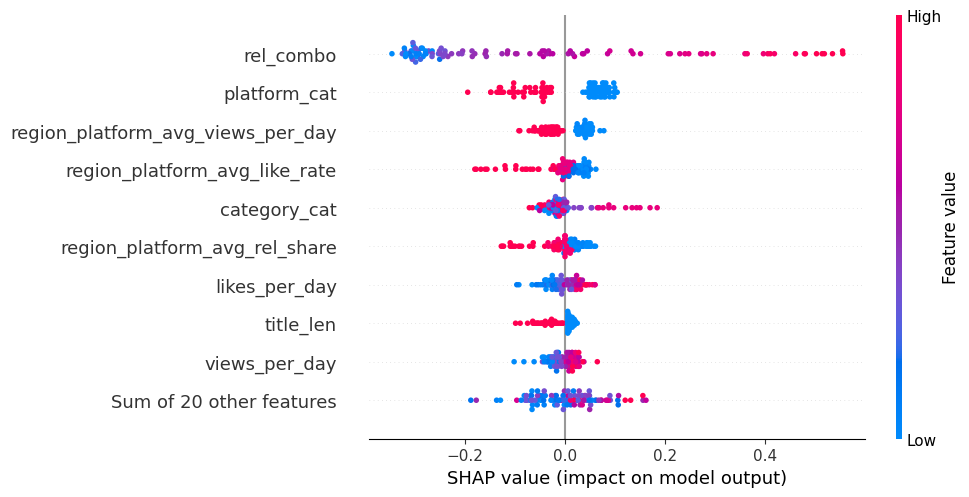

In [149]:
X_bg = X_train.sample(200, random_state=42)
X_explain = X_test.sample(100, random_state=42)

explainer = shap.Explainer(lambda data: model.predict_proba(data), X_bg, feature_names=features)
shap_values = explainer(X_explain)
classes = list(getattr(model, "class_labels_", model.named_steps["model"].classes_))
cls_idx = classes.index("trending") if "trending" in classes else 0
shap.plots.beeswarm(shap_values[:, :, cls_idx], max_display=10)






In [150]:

rf = RandomForestClassifier(n_estimators=400, random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, pred_rf))
print("Macro F1:", f1_score(y_test, pred_rf, average='macro'))
print(confusion_matrix(y_test, pred_rf))
print(classification_report(y_test, pred_rf))


Accuracy: 0.8376
Macro F1: 0.7983701966936328
[[5888  197  395]
 [ 230  775   15]
 [ 775   12 1713]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      6480
           1       0.79      0.76      0.77      1020
           2       0.81      0.69      0.74      2500

    accuracy                           0.84     10000
   macro avg       0.82      0.78      0.80     10000
weighted avg       0.84      0.84      0.83     10000



In [151]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# CV for RandomForest (use your fitted rf)
cv_rf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(rf, X, y, cv=cv_rf, scoring="f1_macro", n_jobs=1)  # <- force single process
print("RF CV macro F1 (mean ± std):", cv_scores_rf.mean(), cv_scores_rf.std())


# CV for XGB+SMOTE (use your fitted pipeline / cv already defined as cv)
cv_scores_xgb = cv_scores  # if you already computed; otherwise:
# cv_scores_xgb = cross_val_score(pipeline, X, y_enc, cv=cv, scoring="f1_macro", n_jobs=-1)
print("XGB+SMOTE CV macro F1 (mean ± std):", cv_scores_xgb.mean(), cv_scores_xgb.std())


RF CV macro F1 (mean ± std): 0.789757727821426 0.0033951248723297486
XGB+SMOTE CV macro F1 (mean ± std): 0.788891121947246 0.002990876348184559


In [152]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=3000, multi_class="multinomial")
log_reg.fit(X_train, y_train)  # use y_enc if you’re encoding; otherwise y_train

# CV for logistic regression
cv_log = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores_log = cross_val_score(log_reg, X, y, cv=cv_log, scoring="f1_macro", n_jobs=1)
print("LogReg CV macro F1 (mean ± std):", cv_scores_log.mean(), cv_scores_log.std())

# Holdout metrics for log_reg
pred_log = log_reg.predict(X_test)
print("LogReg Holdout acc:", accuracy_score(y_test, pred_log))
print("LogReg Holdout macro F1:", f1_score(y_test, pred_log, average="macro"))


c:\Users\indyj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  number for verbosity.
c:\Users\indyj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  number for verbosity.
c:\Users\indyj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  number for verbosity.
c:\Users\indyj\AppData\Lo

LogReg CV macro F1 (mean ± std): 0.7499587745732145 0.004812626945184792
LogReg Holdout acc: 0.8262
LogReg Holdout macro F1: 0.7592330635732999


In [153]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Build a small MLP with scaling
mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        alpha=1e-4,
        max_iter=500,
        random_state=42
    )),
])

# Use encoded labels if you’re encoding (y_enc); otherwise y
y_for_fit = y_enc if "y_enc" in globals() else y
X_for_fit = X

# CV (keep n_jobs=1 if you’ve had joblib issues)
cv_mlp = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores_mlp = cross_val_score(mlp, X_for_fit, y_for_fit, cv=cv_mlp, scoring="f1_macro", n_jobs=1)
print("MLP CV macro F1 (mean ± std):", cv_scores_mlp.mean(), cv_scores_mlp.std())

# Fit and holdout metrics
mlp.fit(X_train, y_train if "y_enc" not in globals() else y_train)
pred_mlp = mlp.predict(X_test)
print("MLP Holdout acc:", accuracy_score(y_test, pred_mlp))
print("MLP Holdout macro F1:", f1_score(y_test, pred_mlp, average="macro"))


MLP CV macro F1 (mean ± std): 0.7615775092727576 0.005506952378015037
MLP Holdout acc: 0.8205
MLP Holdout macro F1: 0.7787299753399742


In [154]:
sample_rows = df_clean.sample(5, random_state=42)  # or remove if not needed

test_videos = [
    row[features].to_dict()
    for _, row in balanced_samples.iterrows()
]

for _, row in sample_rows.iterrows():
    test_videos.append(row[features].to_dict())

for i, video in enumerate(test_videos):
    print(f"\n--- Test Video {i+1} ---")
    display(pd.DataFrame(video, index=[0]))



--- Test Video 1 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,2,1.999998,0.31263,0.108264,0.071943,0.099262,0.031032,0.543434,0.319764,0.117476,...,9.99999,0,0.12588,0.236992,0.074647,0.153687,0.304208,0.0,1.0,0.999999



--- Test Video 2 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,2,1.999998,0.095362,0.051064,0.063192,0.115633,0.011027,-0.530667,0.26782,-0.118992,...,3.999996,0,0.103244,0.203507,0.059564,0.004827,0.106287,0.4588,1.0,0.999999



--- Test Video 3 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,3,2.999997,0.145759,0.013734,0.073121,0.129991,0.018947,-0.263997,0.380983,0.05511,...,17.999982,0,0.125526,0.229555,0.071589,0.146339,0.338209,0.0,1.0,0.999999



--- Test Video 4 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,2,1.999998,0.104763,0.14361,0.021985,0.078946,0.008271,-0.479995,-0.564441,-0.390184,...,9.99999,1,0.103872,0.205414,0.059469,0.014196,0.125933,0.1511,1.0,0.999999



--- Test Video 5 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,3,2.999997,0.194003,0.023569,0.030055,0.087457,0.016967,0.041162,-0.393322,-0.168624,...,5.999994,0,0.125706,0.23011,0.070345,0.146654,0.314137,0.0,1.0,0.999999



--- Test Video 6 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,2,1.999998,0.195775,0.032778,0.015112,0.077575,0.015187,-0.001829,-0.771241,-0.251533,...,11.999988,0,0.102893,0.201018,0.058062,0.007515,0.058156,0.0,1.0,0.999999



--- Test Video 7 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,3,2.999997,0.306942,0.042264,0.211661,0.09342,0.028674,0.543064,3.010121,0.360421,...,14.999985,0,0.103244,0.203507,0.059564,0.004827,0.106287,0.0,1.0,0.999999



--- Test Video 8 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,3,2.999997,0.215186,0.097574,0.148062,0.144049,0.030997,0.100915,1.811657,0.383473,...,5.999994,0,0.125526,0.229555,0.071589,0.146339,0.338209,0.0,1.0,0.999999



--- Test Video 9 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,3,2.999997,0.372525,0.058916,0.083214,0.079847,0.029745,0.991586,0.588896,0.178818,...,8.999991,1,0.103177,0.207272,0.060234,0.029899,0.119752,0.1511,1.0,0.999999



--- Test Video 10 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,3,2.999997,0.334572,0.049647,0.060681,0.12032,0.040256,0.682384,0.169166,0.25556,...,5.999994,0,0.103101,0.203117,0.058582,0.015032,0.096152,0.4939,1.0,0.999999



--- Test Video 11 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,2,1.999998,0.159517,0.110338,0.003468,0.085519,0.013642,-0.177843,-0.938238,-0.292968,...,3.999996,0,0.103274,0.209323,0.06291,0.018273,0.099448,0.0,1.0,0.999999



--- Test Video 12 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,2,1.999998,0.12236,0.006508,0.062449,0.072767,0.008904,-0.428182,0.046163,-0.334512,...,1.999998,0,0.103101,0.203117,0.058582,0.015032,0.096152,0.0,1.0,0.999999



--- Test Video 13 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,2,1.999998,0.215434,0.176926,0.039674,0.126407,0.027232,-0.020723,-0.357441,0.027257,...,3.999996,0,0.12588,0.236992,0.074647,0.153687,0.304208,0.0,1.0,0.999999



--- Test Video 14 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment,trending_hashtag_hits,trending_hashtag_ratio
0,2,1.999998,0.143176,0.235728,0.051427,0.105363,0.015085,-0.33209,-0.16043,-0.15741,...,9.99999,1,0.103274,0.209323,0.06291,0.018273,0.099448,0.0,1.0,0.999999


In [155]:


platform_map = df[['platform', 'platform_cat']].drop_duplicates().set_index('platform_cat')['platform'].to_dict()

region_map = df[['region', 'region_cat']].drop_duplicates().set_index('region_cat')['region'].to_dict()

for i, video in enumerate(test_videos):
    pred, score = rate_video(video, model)
    score_text = f"{score:.2f}/100" if score is not None else "n/a"
    print(f"Video {i+1}:")
    print(f"  Predicted Category: {pred}")
    print(f"  Trending Score: {score_text}")

    
    print(f"Platform: {platform_map[video['platform_cat']]}")
    print(f"Region: {region_map[video['region_cat']]}")

    
    if score > 60:
        print("  Interpretation: This video is highly likely to trend.")
    elif score > 20:
        print("  Interpretation: Decent performance but not strong enough to trend.")
    else:
        print("  Interpretation: Weak performance relative to region/platform norms.")
    
    print()






Video 1:
  Predicted Category: likely
  Trending Score: 39.28/100
Platform: tiktok
Region: Asia
  Interpretation: Decent performance but not strong enough to trend.

Video 2:
  Predicted Category: likely
  Trending Score: 0.99/100
Platform: youtube
Region: Europe
  Interpretation: Weak performance relative to region/platform norms.

Video 3:
  Predicted Category: likely
  Trending Score: 5.93/100
Platform: tiktok
Region: Americas
  Interpretation: Weak performance relative to region/platform norms.

Video 4:
  Predicted Category: low
  Trending Score: 0.31/100
Platform: youtube
Region: Africa
  Interpretation: Weak performance relative to region/platform norms.

Video 5:
  Predicted Category: likely
  Trending Score: 0.68/100
Platform: tiktok
Region: MENA
  Interpretation: Weak performance relative to region/platform norms.

Video 6:
  Predicted Category: low
  Trending Score: 0.60/100
Platform: youtube
Region: Oceania
  Interpretation: Weak performance relative to region/platform norm

In [156]:
import os, sklearn, joblib
print("Train sklearn:", sklearn.__version__)
os.makedirs("../models", exist_ok=True)
joblib.dump(model, "../models/trend_model.pkl")
print("Saved to ../models/trend_model.pkl")
print(os.path.exists("../models/trend_model.pkl"))

Train sklearn: 1.7.2
Saved to ../models/trend_model.pkl
True


In [157]:
import os
print(os.path.exists("../models/trend_model.pkl"))

True


In [158]:
# Save feature list and model for app explanations
import joblib, os
feature_list_path = "../models/feature_list.pkl"
model_path = "../models/trend_model.pkl"  # reuse existing name
os.makedirs("../models", exist_ok=True)
joblib.dump(features, feature_list_path)
joblib.dump(pipeline, model_path)
joblib.dump(le, "../models/label_encoder.pkl")

print("Saved feature list to", feature_list_path)
print("Re-saved model to", model_path)
print("Feature count:", len(features))

Saved feature list to ../models/feature_list.pkl
Re-saved model to ../models/trend_model.pkl
Feature count: 29


In [159]:
import json, os
from sklearn.metrics import accuracy_score, f1_score

def eval_model(clf, X_test, y_test, le=None):
    preds = clf.predict(X_test)
    y_true = y_test
    if le is not None:
        preds = le.inverse_transform(preds)
        y_true = le.inverse_transform(y_test)
    return {
        "acc": accuracy_score(y_true, preds),
        "f1_macro": f1_score(y_true, preds, average="macro"),
    }

results = {}

if "log_reg" in globals():
    results["log_reg"] = {
        "cv_f1_mean": cv_scores_log.mean(),
        "cv_f1_std": cv_scores_log.std(),
        **eval_model(log_reg, X_test, y_test, le if "le" in globals() else None),
    }

if "rf" in globals():
    results["random_forest"] = {
        "cv_f1_mean": cv_scores_rf.mean(),
        "cv_f1_std": cv_scores_rf.std(),
        **eval_model(rf, X_test, y_test, le if "le" in globals() else None),
    }
if "mlp" in globals():
    results["mlp"] = {
        "cv_f1_mean": cv_scores_mlp.mean(),
        "cv_f1_std": cv_scores_mlp.std(),
        **eval_model(mlp, X_test, y_test, le if "le" in globals() else None),
    }

if "pipeline" in globals():  # XGB+SMOTE
    results["xgb_smote"] = {
        "cv_f1_mean": cv_scores.mean(),   # your XGB CV
        "cv_f1_std": cv_scores.std(),
        **eval_model(pipeline, X_test, y_test, le),
    }
    results["selected"] = "xgb_smote"

metrics_path = "../models/metrics.json"
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
with open(metrics_path, "w") as f:
    json.dump(results, f, indent=2)

print("Saved metrics to", metrics_path)


Saved metrics to ../models/metrics.json
